<a href="https://colab.research.google.com/github/YTWTY/Recognition-and-Segmentation-in-Anime-Eyes/blob/main/src/Dino_SAM_eye_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anime Characters Eye Detection and Segment Using Grounding DINO & SAM
## Introduction to Grounding DINO:
Grounding DINO is a powerful self-supervised learning algorithm primarily used for computer vision tasks. It is specifically designed to learn useful feature representations from images without relying on labeled data.

Grounding DINO excels in various computer vision tasks, especially those that require understanding complex and rich visual content. Due to its self-supervised nature, Grounding DINO is particularly effective in processing unlabeled data sets. It can effectively learn rich and useful feature representations from unlabeled images, providing a powerful tool for leveraging large-scale unlabeled data.

## Introduction to SAM:
SAM (Segment Anything Model) is an advanced image segmentation model. It can automatically identify and segment objects in images based on user's interactive input, demonstrating powerful real-time interaction capabilities and adaptability. SAM shows exceptional segmentation performance in various complex environments when trained on a large and diverse dataset.

## Goal:
In this notebook, we will first employ Dino for object detection. Then use SAM to segment the object based on the detected results. Subsequently, we will present and analyze the outcomes of these processes.

## Preparation to run code:
Download the dataset from [Anime characters eye dataset](https://universe.roboflow.com/erentil/both-eyes-anime/dataset/2) and upload the zip file, or you can use the code on the website to download it

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Install Grounding DINO and SAM

Our project will use [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) for object detection and [SAM (Segment Anything Model)](https://github.com/facebookresearch/segment-anything) for converting boxes into segmentations.


In [2]:
import os
import sys
home = os.getcwd()
%cd {home}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
%cd {home}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .
%cd {home}

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 415, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 415 (delta 136), reused 126 (delta 122), pack-reused 237
Receiving objects: 100% (415/415), 12.85 MiB | 2.62 MiB/s, done.
Resolving deltas: 100% (213/213), done.
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-bg56o88h
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-bg56o88h
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=3973ed869753c6bcddb61b87d33c9e0dca19f48d93c8eb5e1fa761b2c34db764
  Stored in directory: /tmp/pip-ephem-wheel-cache-03w16j0z/wheels/10/cf/59/9ccb2

In [3]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.


### Download Weights for Grounding DINO Model


In [4]:
import os
DINO_config = os.path.join(home, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")

In [5]:
%cd {home}
!mkdir -p {home}/weights
%cd {home}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

/content
/content/weights


In [6]:
import os
DINO_checkpoint = os.path.join(home, "weights", "groundingdino_swint_ogc.pth")

### Download Weights for SAM


In [7]:
%cd {home}
!mkdir -p {home}/weights
%cd {home}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [8]:
import os
SAM_checkpoint = os.path.join(home, "weights", "sam_vit_h_4b8939.pth")

# Load and Train models
Load the model and configuration from the libaray

In [9]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Grounding DINO Model

In [10]:
%cd {home}/GroundingDINO
from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=DINO_config, model_checkpoint_path=DINO_checkpoint)

/content/GroundingDINO


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Load Segment Anything Model

In [11]:
from segment_anything import sam_model_registry, SamPredictor

# Initialize the SAM model
sam = sam_model_registry['vit_h'](checkpoint=SAM_checkpoint).to(device=DEVICE)
# Create a predictor object for the SAM model.
sam_predictor = SamPredictor(sam)

In [12]:
import numpy as np

def segment(sam_predictor, image, xyxy):
    sam_predictor.set_image(image)
    masks = []

    # Iterate through each bounding box
    for box in xyxy:
      # Perform prediction using SAM for the given box
      m, s, _ = sam_predictor.predict(box=box, multimask_output=True)
      masks.append(m[np.argmax(s)])
    return np.array(masks)

# Download Example Data

The program will automatically download some test images from [Roboflow](https://universe.roboflow.com/), and the subsequent code will use these images by default. If you wish to use different images, you can upload the downloaded images to the '{home}/data/' folder and change the value of 'current_images' in the later code to 'images_set1' ('images_set1' refers to the files uploaded manually; 'images_set2' refers to the default test images; 'current_images' is set to 'images_set2' by default).


In [19]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
groundingdino 0.1.0 requires super

In [20]:
%cd {home}
!mkdir {home}/data

%cd {home}
from roboflow import Roboflow
rf = Roboflow(api_key="WCBk34Jy5rbBcr5QscEu")
project = rf.workspace("erentil").project("both-eyes-anime")
dataset = project.version(2).download("yolov8")

/content
mkdir: cannot create directory ‘/content/data’: File exists
/content
loading Roboflow workspace...
loading Roboflow project...
[WARNING] we noticed you are downloading a `yolov8` datasets but you don't have `ultralytics` installed. Roboflow `.deploy` supports only models trained with `ultralytics==8.0.196`, to intall it `pip install ultralytics==8.0.196`.



Extracting Dataset Version Zip to both-eyes-anime-2 in yolov8:: 100%|██████████| 248/248 [00:00<00:00, 6439.43it/s]


# Dataset Mask Auto Annotation

In [14]:
import os
images_set1 = os.path.join(home, 'data')
images_set2 = os.path.join(home, 'both-eyes-anime-2/test/images')

In [21]:
# If you wish to use different images:
# Change the value of 'current_images' here to 'images_set1' after upload the downloaded images to the '{Home}/data/' folder.
# - 'images_set1' refers to the files uploaded manually;
# - 'images_set2' refers to the default test images;
# - 'current_images' is set to 'images_set2' by default.
current_images = images_set2

In [16]:
!pip install memory_profiler

In [22]:
import cv2
from tqdm.notebook import tqdm
import time
from memory_profiler import memory_usage

images = {}
annotations = {}
image_paths = sv.list_files_with_extensions(directory=current_images, extensions=['jpg', 'jpeg', 'png'])

def process_image(image_paths):
  # Iterate through each image
  for image_path in tqdm(image_paths):
    image = cv2.imread(str(image_path))

    # Record the start time
    start_time = time.time()
    # Use the Grounding DINO model to predict the presence of 'eye' class
    detections = grounding_dino_model.predict_with_classes(image=image, classes=['eye'], box_threshold=0.35, text_threshold=0.25)
    # Record the end time
    end_time = time.time()

    # Use the SAM model to segment the image based on the detections.
    detections.mask = segment(sam_predictor=sam_predictor, image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB), xyxy=detections.xyxy)
    images[image_path.name] = image
    annotations[image_path.name] = detections

    print(f'Processing image took: {end_time - start_time} seconds')

# Measure the peak memory usage
mem_usage = memory_usage((process_image, (image_paths,)))
print(f"Peak memory usage: {max(mem_usage)} MB")

  0%|          | 0/5 [00:00<?, ?it/s]

The `device` argument is deprecated and will be removed in v5 of Transformers.
torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None


Processing image took: 0.2904086112976074 seconds
Processing image took: 0.1763765811920166 seconds
Processing image took: 0.17779183387756348 seconds
Processing image took: 0.18126177787780762 seconds
Processing image took: 0.13976240158081055 seconds
Peak memory usage: 2277.9453125 MB


# Visual results

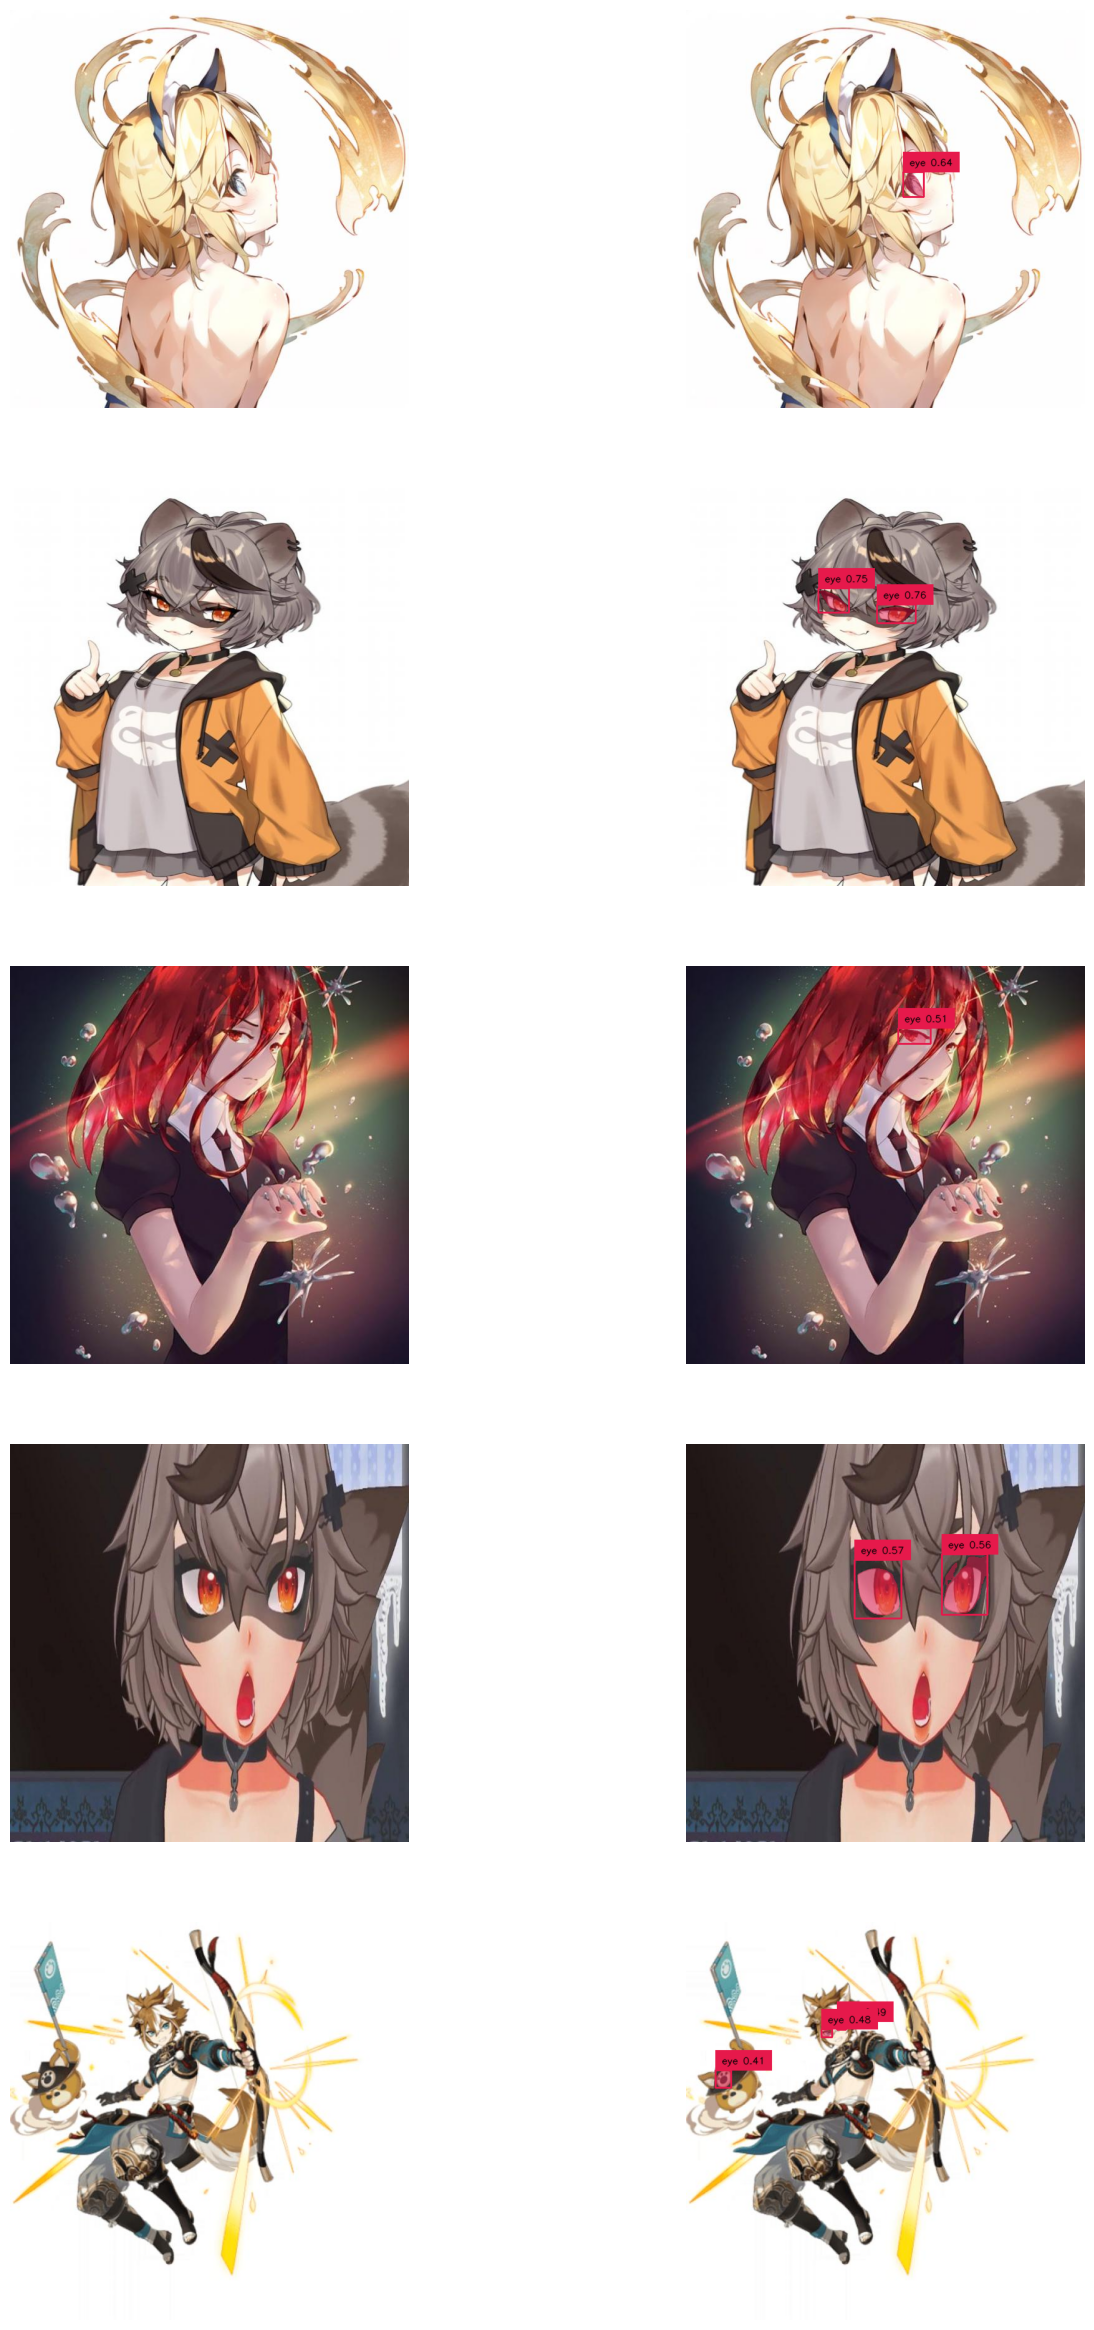

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(annotations), 2, figsize=(8 * 2, len(annotations) * 6))

for i, (image_name, detections) in enumerate(annotations.items()):
    # Generate labels for each detection
    labels = [f"eye {confidence:0.2f}" for confidence in detections.confidence]

    # Create annotated images
    annotated_image = sv.MaskAnnotator().annotate(scene=images[image_name], detections=detections)
    annotated_image = sv.BoxAnnotator().annotate(scene=annotated_image, detections=detections, labels=labels)

    # Plot the original image
    axes[i, 0].imshow(cv2.cvtColor(images[image_name], cv2.COLOR_BGR2RGB))
    axes[i, 0].axis('off')

    # Plot the annotated image
    axes[i, 1].imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    axes[i, 1].axis('off')

plt.show()